# CONVOLUTIONAL NEURAL NETWORK (CNN) FOR CASTING PRODUCT QUALITY INSPECTION

Casting is a manufacturing process in which liquid material is poured into a mold to solidify. Many types of defects or unwanted irregularities can occur during this process. The industry has its quality inspection department to remove defective products from the production line, but this is very time consuming since it is carried out manually. Furthermore, there is a chance of misclassifying due to human error, causing rejection of the whole product order.

In this notebook, let us automate the inspection process by training top-view images of a casted submersible pump impeller using a Convolutional Neural Network (CNN) so that it can distinguish accurately between `defect` from the `ok` one.

We will break down into several steps:

1. Load the images and apply the data augmentation technique

2. Visualize the images

3. Training with validation: define the architecture, compile the model, model fitting and evaluation
    
4. Testing on unseen images

5. Make a conclusion

# Import Libraries
As usual, before we begin any analysis and modeling, let's import several necessary libraries to work with the data.

In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Neural Network Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


# Load the Images

Here is the structure of our folder containing image data:

    casting_data
    ├───test
    │   ├───def_front
    │   └───ok_front
    └───train
        ├───def_front
        └───ok_front
     
The folder `casting_data` consists of two subfolders `test` and `train` in which each of them has another subfolder: `def_front` and `ok_front` denoting the class of our target variable. The images inside `train` will be used for model fitting and validation, while `test` will be used purely for testing the model performance on unseen images.

## Data Augmentation

We apply on-the-fly data augmentation, a technique to expand the training dataset size by creating a modified version of the original image which can improve model performance and the ability to generalize. This can be achieved by using `ImageDataGenerator` provided by `keras` with the following parameters:

- `rotation_range`: Degree range for random rotations. We choose 360 degrees since the product is a round object.
- `width_shift_range`: Fraction range of the total width to be shifted.
- `height_shift_range`: Fraction range of the total height to be shifted.
- `shear_range`: Degree range for random shear in a counter-clockwise direction.
- `zoom_range`: Fraction range for random zoom.
- `horizontal_flip` and `vertical_flip` are set to `True` for randomly flip image horizontally and vertically.
- `brightness_range`: Fraction range for picking a brightness shift value.

Other parameters:
- `rescale`: Eescale the pixel values to be in range 0 and 1.
- `validation_split`: Reserve 20% of the training data for validation, and the rest 80% for model fitting.

In [2]:
train_generator = ImageDataGenerator(rotation_range = 360,
                                     width_shift_range = 0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range = [0.75, 1.25],
                                     rescale = 1./255,
                                     validation_split = 0.2)

We define another set of value for the `flow_from_directory` parameters:
- `IMAGE_DIR`: The directory where the image data is stored.
- `IMAGE_SIZE`: The dimension of the image (300 px by 300 px).
- `BATCH_SIZE`: Number of images that will be loaded and trained at one time.
- `SEED_NUMBER`: Ensure reproducibility.

- `color_mode = "grayscale"`: Treat our image with only one channel color.
- `class_mode` and `classes` define the target class of our problem. In this case, we denote the `defect` class as positive (1), and `ok` as a negative class.
- `shuffle = True` to make sure the model learns the `defect` and `ok` images alternately.

In [3]:
IMAGE_DIR = "/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/"
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 64
SEED_NUMBER = 123

gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1},
                shuffle = True,
                seed = SEED_NUMBER)

train_dataset = train_generator.flow_from_directory(directory = IMAGE_DIR + "train",
                                                    subset = "training", **gen_args)
validation_dataset = train_generator.flow_from_directory(directory = IMAGE_DIR + "train",
                                                         subset = "validation", **gen_args)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.


We will not perform any data augmentation on the test data.

In [4]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_dataset = test_generator.flow_from_directory(directory = IMAGE_DIR + "test",
                                                  **gen_args)

Found 715 images belonging to 2 classes.


## Image Data Proportion
We successfully load and apply on-the-fly data augmentation according to the specified parameters. Now, let's take a look on how is the proportion of the `train`, `validation`, and `test` image for each class.

In [5]:
image_data = [{"data": typ,
               "class": name.split('/')[0],
               "filename": name.split('/')[1]}
              for dataset, typ in zip([train_dataset, validation_dataset, test_dataset], ["train", "validation", "test"])
              for name in dataset.filenames]
image_df = pd.DataFrame(image_data)
data_crosstab = pd.crosstab(index = image_df["data"],
                            columns = image_df["class"],
                            margins = True,
                            margins_name = "Total")
data_crosstab

class,def_front,ok_front,Total
data,,,
test,453,262,715
train,3007,2300,5307
validation,751,575,1326
Total,4211,3137,7348


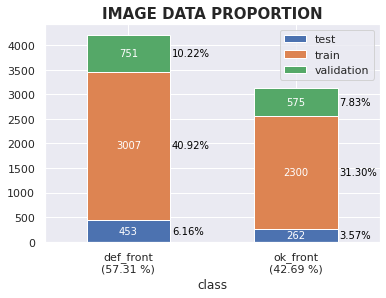

In [6]:
total_image = data_crosstab.iloc[-1,-1]
ax = data_crosstab.iloc[:-1,:-1].T.plot(kind = "bar", stacked = True, rot = 0)

percent_val = []

for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    percent = 100*height/total_image

    ax.text(rect.get_x() + width - 0.25, 
            rect.get_y() + height/2, 
            int(height), 
            ha = 'center',
            va = 'center',
            color = "white",
            fontsize = 10)
    
    ax.text(rect.get_x() + width + 0.01, 
            rect.get_y() + height/2, 
            "{:.2f}%".format(percent), 
            ha = 'left',
            va = 'center',
            color = "black",
            fontsize = 10)
    
    percent_val.append(percent)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles, labels = labels)

percent_def = sum(percent_val[::2])
ax.set_xticklabels(["def_front\n({:.2f} %)".format(percent_def), "ok_front\n({:.2f} %)".format(100-percent_def)])
plt.title("IMAGE DATA PROPORTION", fontsize = 15, fontweight = "bold")
plt.show()

We will proceed to the next step, since the proportion of data can be considered as balanced.

# Visualize the Image
In this section, we visualize the image to make sure that it is loaded correctly.

## Visualize Image in Batch

Visualize the first batch (`BATCH_SIZE = 64`) of the training dataset (images with data augmentation) and also the test dataset (images without data augmentation).

In [7]:
mapping_class = {0: "ok", 1: "defect"}
mapping_class

{0: 'ok', 1: 'defect'}

In [8]:
def visualizeImageBatch(dataset, title):
    images, labels = next(iter(dataset))
    images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
    fig, axes = plt.subplots(8, 8, figsize=(16,16))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 20)

    plt.tight_layout()
    fig.suptitle(title, size = 30, y = 1.05, fontweight = "bold")
    plt.show()
    
    return images

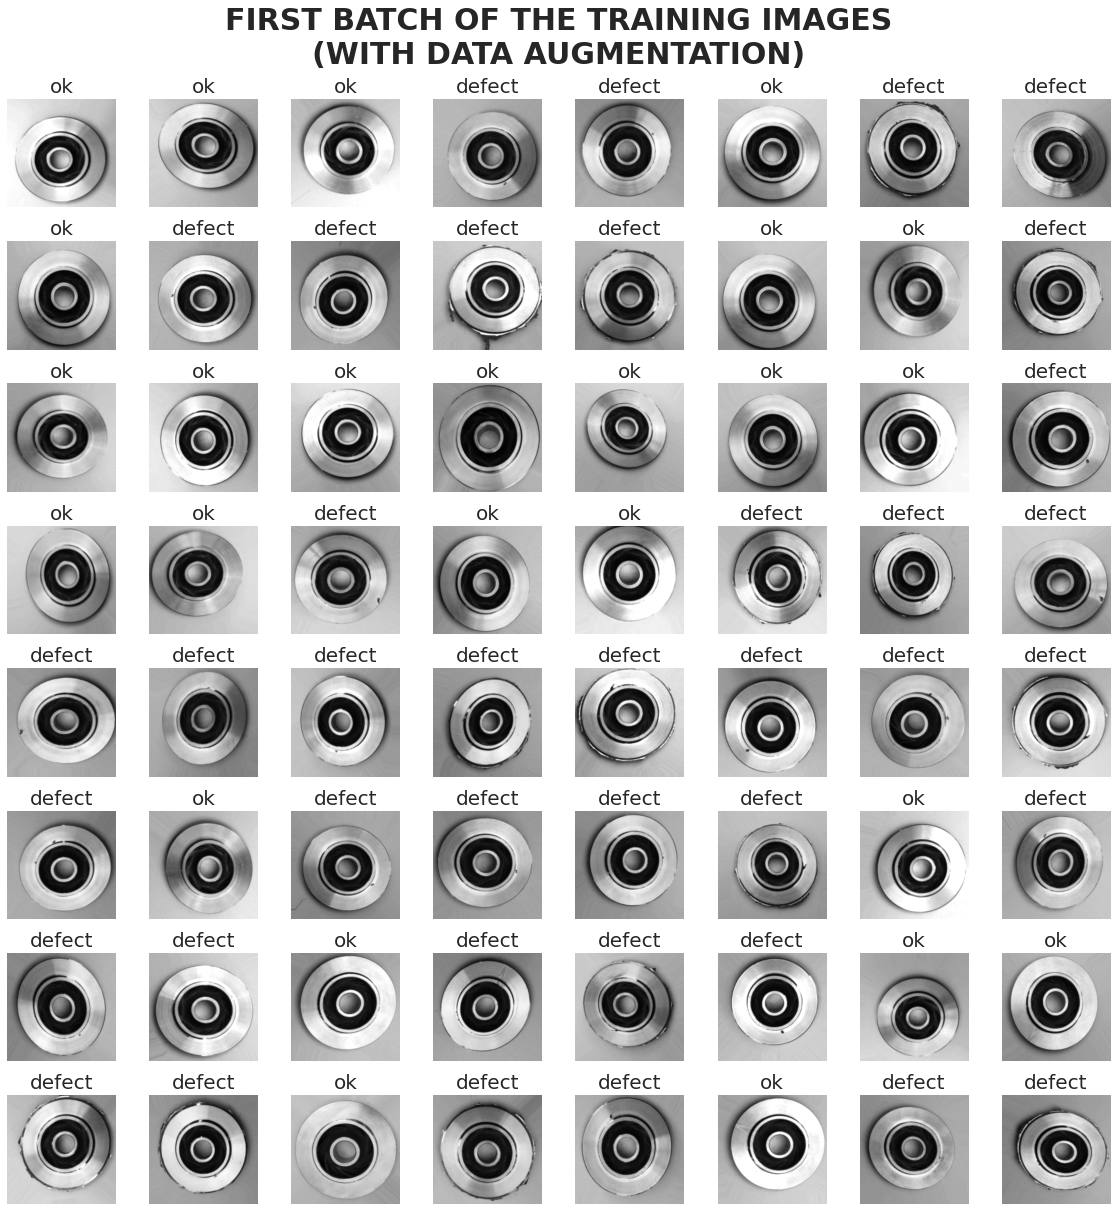

In [9]:
train_images = visualizeImageBatch(train_dataset,
                                   "FIRST BATCH OF THE TRAINING IMAGES\n(WITH DATA AUGMENTATION)")

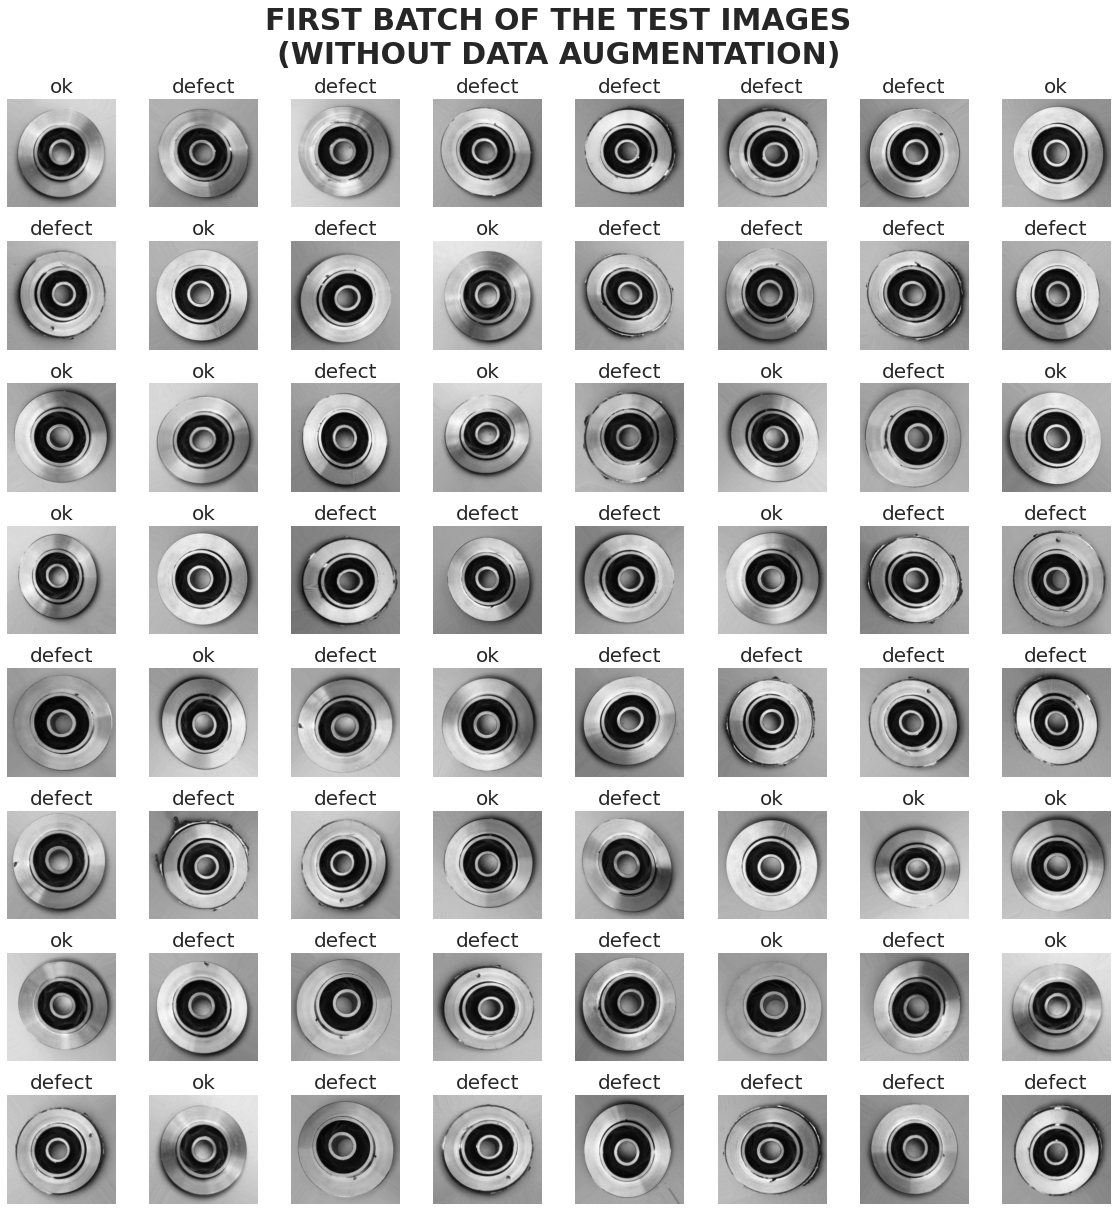

In [10]:
test_images = visualizeImageBatch(test_dataset,
                                  "FIRST BATCH OF THE TEST IMAGES\n(WITHOUT DATA AUGMENTATION)")

## Visualize Detailed Image
Let's also take a look on the detailed image by each pixel. Instead of plotting 300 pixels by 300 pixels (which computationally expensive), we take a small part of 25 pixels by 25 pixels only.

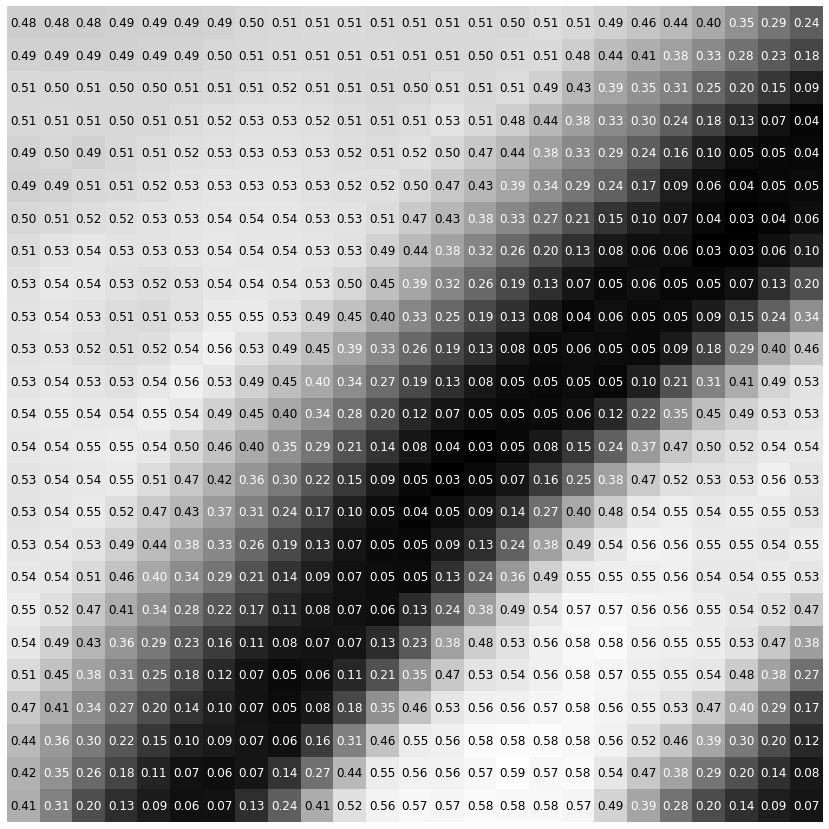

In [11]:
img = np.squeeze(train_images[4])[75:100, 75:100]

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = "gray")
ax.axis("off")

w, h = img.shape
for x in range(w):
    for y in range(h):
        value = img[x][y]
        ax.annotate("{:.2f}".format(value), xy = (y,x),
                    horizontalalignment = "center",
                    verticalalignment = "center",
                    color = "white" if value < 0.4 else "black")

These are the example of values that we are going to feed into our CNN architecture.

# Training the Network

As mentioned earlier, we are going to train a CNN model to classify the casting product image. CNN is used as an automatic feature extractor from the images so that it can learn how to distinguish between `defect` and `ok` casted products. It effectively uses the adjacent pixel to downsample the image and then use a prediction (fully-connected) layer to solve the classification problem. This is a simple illustration by [Udacity](https://github.com/udacity/deep-learning-v2-pytorch) on how the layers are arranged sequentially:

<img src = "https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/convolutional-neural-networks/conv-visualization/notebook_ims/CNN_all_layers.png" height=50% width=50%>

## Define Architecture

Here is the detailed architecture that we are going to use:
1. **First convolutional layer**: consists of 32 `filters` with `kernel_size` matrix 3 by 3. Using 2-pixel `strides` at a time, reduce the image size by half.
2. **First pooling layer**: Using max-pooling matrix 2 by 2 (`pool_size`) and 2-pixel `strides` at a time further reduce the image size by half.
3. **Second convolutional layer**: Just like the first convolutional layer but with 16 `filters` only.
4. **Second pooling layer**: Same as the first pooling layer.
5. **Flattening**: Convert two-dimensional pixel values into one dimension, so that it is ready to be fed into the fully-connected layer.
6. **First dense layer + Dropout**: consists of 128 `units` and 1 bias unit. Dropout of `rate` 20% is used to prevent overfitting.
7. **Second dense layer + Dropout**: consists of 64 `units` and 1 bias unit. Dropout of `rate` 20% is also used to prevent overfitting.
8. **Output layer**: consists of only one `unit` and `activation` is a sigmoid function to convert the scores into a probability of an image being `defect`.

For every layer except output layer, we use Rectified Linear Unit (ReLU) `activation` function as follow:

<img src = "https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/convolutional-neural-networks/conv-visualization/notebook_ims/relu_ex.png" height=50% width=50%>

In [12]:
model = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               activation = "relu",
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(64, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(1, activation = "sigmoid")
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 149, 149, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               663680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

## Compile the Model
Next, we specify how the model backpropagates or update the weights after each batch feed-forward. We use adam `optimizer` and a `loss` function binary cross-entropy since we are dealing with binary classification problem. The `metrics` used to monitor the training progress is accuracy.

In [13]:
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

## Model Fitting
Before we do model fitting, let's check whether GPU is available or not.

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4517394187539955928
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1911544242970744589
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5551933093190546211
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15870492672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9283041692306277874
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


For each epoch, `batch_size` $\times$ `steps_per_epoch` images will be fed into our CNN architecture. In this case, we specify the `steps_per_epoch` to be 150 so for each epoch `64 * 150 = 9600` augmented images from the training dataset will be fed. We let the model train for 25 `epochs`.

By using `ModelCheckpoint`, the best model will be automatically saved if the current `val_loss` is lower than the previous one.

In [15]:
STEPS = 150

checkpoint = ModelCheckpoint("cnn_casting_inspection_model.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

model.fit_generator(generator = train_dataset,
                    validation_data = validation_dataset,
                    steps_per_epoch = STEPS,
                    epochs = 25,
                    validation_steps = STEPS,
                    callbacks = [checkpoint],
                    verbose = 1)

Epoch 1/25
150/150 [==============================] - 166s 1s/step - loss: 0.6243 - accuracy: 0.6327 - val_loss: 0.5896 - val_accuracy: 0.7033

Epoch 00001: val_loss improved from inf to 0.58961, saving model to cnn_casting_inspection_model.hdf5
Epoch 2/25
150/150 [==============================] - 150s 1000ms/step - loss: 0.5075 - accuracy: 0.7515 - val_loss: 0.4829 - val_accuracy: 0.8062

Epoch 00002: val_loss improved from 0.58961 to 0.48288, saving model to cnn_casting_inspection_model.hdf5
Epoch 3/25
150/150 [==============================] - 151s 1s/step - loss: 0.3580 - accuracy: 0.8378 - val_loss: 0.3844 - val_accuracy: 0.8882

Epoch 00003: val_loss improved from 0.48288 to 0.38443, saving model to cnn_casting_inspection_model.hdf5
Epoch 4/25
150/150 [==============================] - 151s 1s/step - loss: 0.2687 - accuracy: 0.8818 - val_loss: 0.2590 - val_accuracy: 0.9073

Epoch 00004: val_loss improved from 0.38443 to 0.25899, saving model to cnn_casting_inspection_model.hdf5


The model achieves 98.21% accuracy on training dataset and 98.42% on validation dataset.

## Training Evaluation

Let's plot both `loss` and `accuracy` metrics for `train` and `validation` data based on each `epoch`.

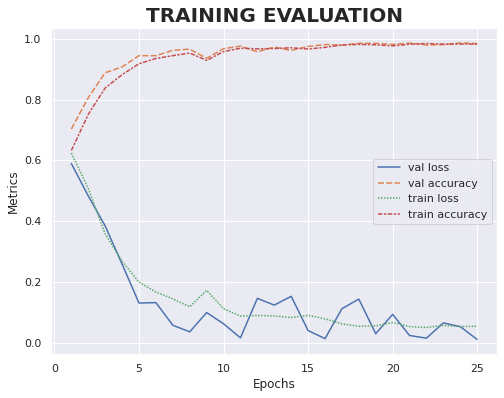

In [16]:
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model.history.history,
                                 index = range(1, 1+len(model.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

We can conclude that the model is **not overfitting** the data since both `train loss` and `val loss` simultaneously dropped towards zero. Also, both `train accuracy` and `val accuracy` increase towards 100%.

# Testing on Unseen Images

Our model performs very well on the training and validation dataset which uses augmented images. Now, we test our model performance with unseen and unaugmented images.

In [55]:
best_model = load_model("/kaggle/working/cnn_casting_inspection_model.hdf5")

In [56]:
y_pred_prob = best_model.predict_generator(generator = test_dataset,
                                           verbose = 1)

12/12 [==============================] - 2s 143ms/step


The output of the prediction is in the form of probability. We use `THRESHOLD = 0.5` to separate the classes. If the probability is greater or equal to the `THRESHOLD`, then it will be classified as `defect`, otherwise `ok`.

In [57]:
THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]

pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["ok", "defect"]],
    columns = [["Predicted", "Predicted"], ["ok", "defect"]],
)

Predicted       
                     ok defect
Actual ok           259      3
       defect         1    452

In [59]:
print(classification_report(y_true_class, y_pred_class, digits = 4))

              precision    recall  f1-score   support

           0     0.9962    0.9885    0.9923       262
           1     0.9934    0.9978    0.9956       453

    accuracy                         0.9944       715
   macro avg     0.9948    0.9932    0.9940       715
weighted avg     0.9944    0.9944    0.9944       715



According to the problem statement, we want to minimize the case of False Negative, where the `defect` product is misclassified as `ok`. This can cause the whole order to be rejected and create a big loss for the company. Therefore, in this case, we prioritize Recall over Precision.

But if we take into account the cost of re-casting a product, we have to minimize the case of False Positive also, where the `ok` product is misclassified as `defect`. Therefore we can prioritize the F1 score which combines both Recall and Precision.

On test dataset, the model achieves a very good result as follow:
- Accuracy: 99.44%
- Recall: 99.78%
- Precision: 99.34%
- F1 score: 99.56%

## Visualize the Results

Lastly, we visualize the results by comparing its true label with the predicted label and also provide the probability of each image being on the predicted class. A <font color=blue><b>blue color</b></font> on the text indicates that our model correctly classify the image, otherwise <font color=red><b>red color</b></font> is used.

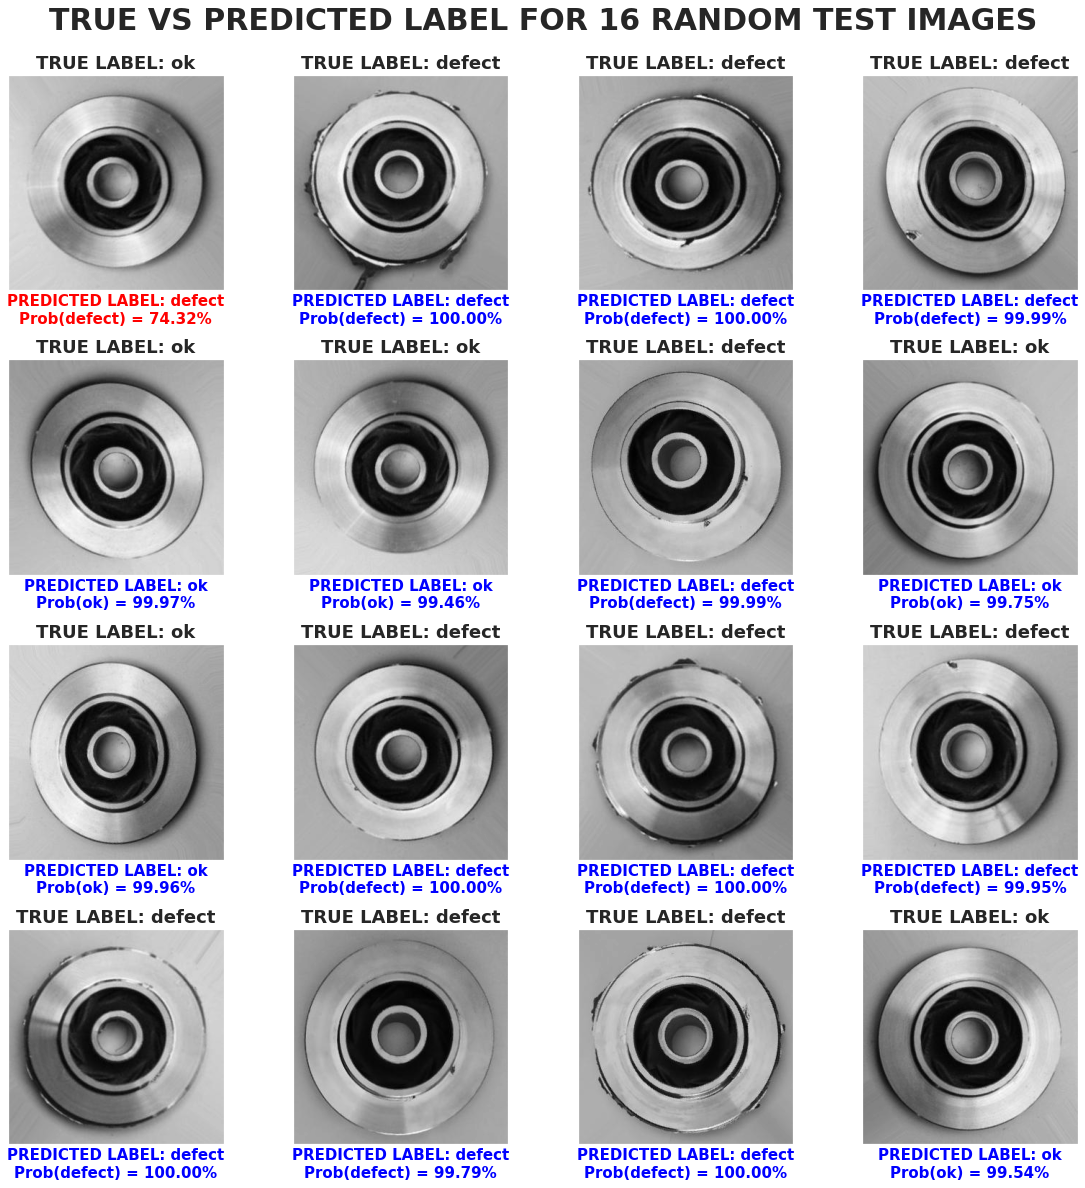

In [50]:
images, labels = next(iter(test_dataset))
images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
fig, axes = plt.subplots(4, 4, figsize=(16,16))

for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap = "gray")
    true_label = mapping_class[label]
    
    [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle("TRUE VS PREDICTED LABEL FOR 16 RANDOM TEST IMAGES", size = 30, y = 1.03, fontweight = "bold")
plt.show()

Since the proportion of correctly classified images is very large, let's also visualize the misclassified only.

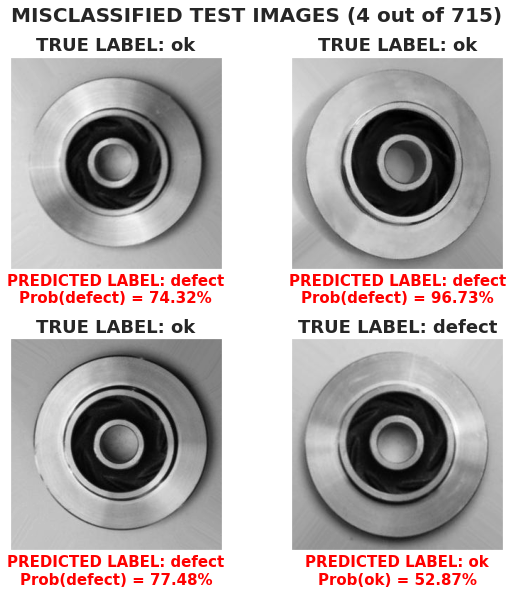

In [60]:
misclassify_pred = np.nonzero(y_pred_class != y_true_class)[0]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, batch_num, image_num in zip(axes.flat, misclassify_pred // BATCH_SIZE, misclassify_pred % BATCH_SIZE):
    images, labels = test_dataset[batch_num]
    img = images[image_num]
    ax.imshow(img.reshape(*IMAGE_SIZE), cmap = "gray")
    
    true_label = mapping_class[labels[image_num]]
    [[pred_prob]] = best_model.predict(img.reshape(1, *IMAGE_SIZE, -1))
    pred_label = mapping_class[int(pred_prob >= THRESHOLD)]
    
    prob_class = 100*pred_prob if pred_label == "defect" else 100*(1-pred_prob)
    
    ax.set_title(f"TRUE LABEL: {true_label}", fontweight = "bold", fontsize = 18)
    ax.set_xlabel(f"PREDICTED LABEL: {pred_label}\nProb({pred_label}) = {(prob_class):.2f}%",
                 fontweight = "bold", fontsize = 15,
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle(f"MISCLASSIFIED TEST IMAGES ({len(misclassify_pred)} out of {len(y_true_class)})",
             size = 20, y = 1.03, fontweight = "bold")
plt.show()

Out of 715 test images, only 4 images are being misclassified. 

# Conclusion

By using CNN and on-the-fly data augmentation, the performance of our model in training, validation, and test images is almost perfect, reaching 98-99% accuracy and F1 score. We can utilize this model by embedding it into a surveillance camera where the system can automatically separate defective product from the production line. This method surely can reduce human error and human resources on manual inspection, but it still needs supervision from human since the model is not 100% correct at all times.